In [21]:
import pandas as pd
import numpy as np
import kaggle
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## 1) Import NFL Draft Data from Kaggle

In [2]:
!kaggle datasets download ronitf/heart-disease-uci -f heart.csv

heart.csv: Skipping, found more recently modified local copy (use --force to force download)


### Explore and clean dataset

In [3]:
# store observations in a dataframe
hd = pd.read_csv("heart.csv")
hd.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
hd.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [5]:
hd.describe()
# note - there are only 303 observations in the dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
hd.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

C:\Users\Eric\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


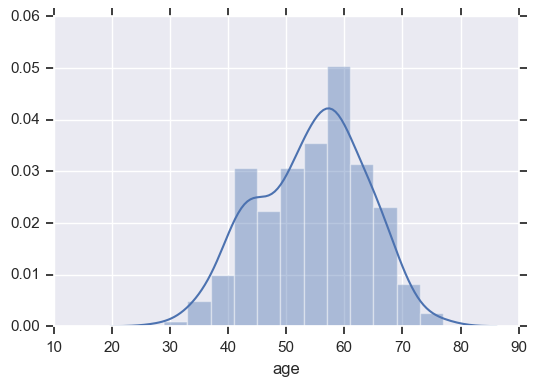

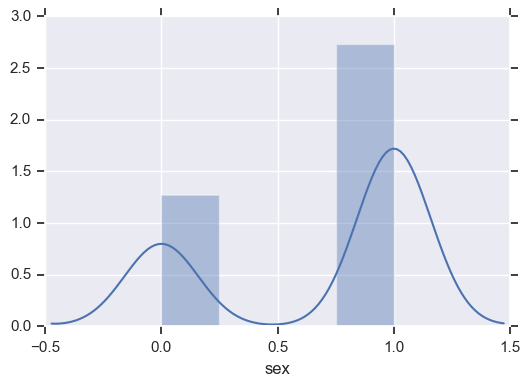

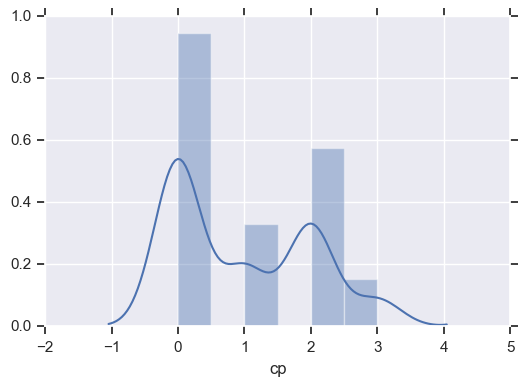

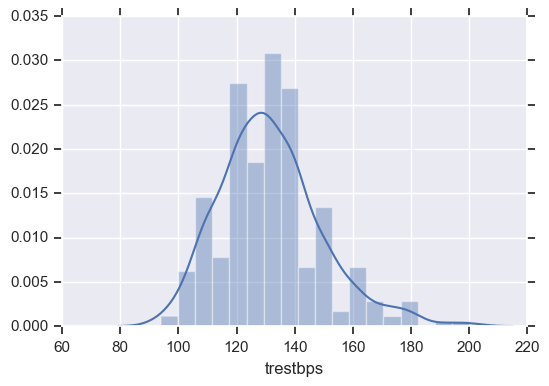

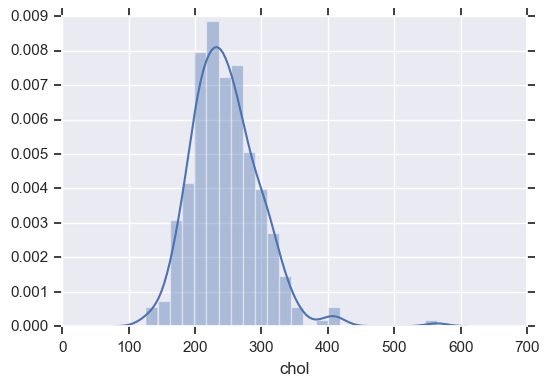

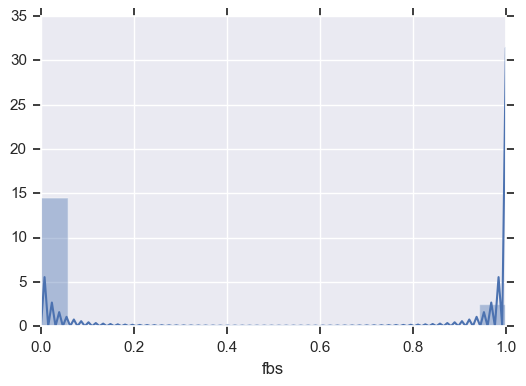

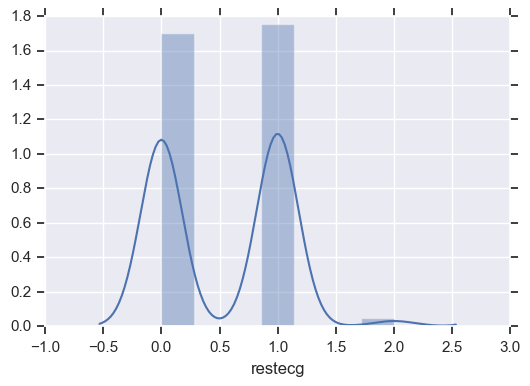

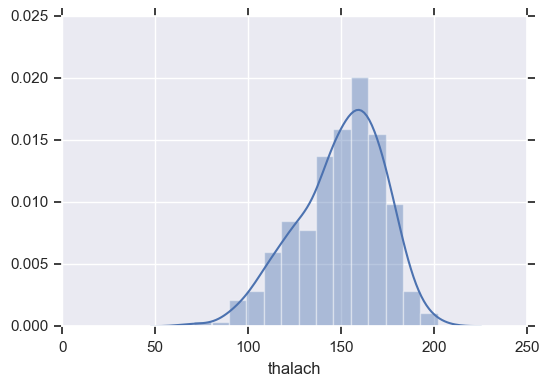

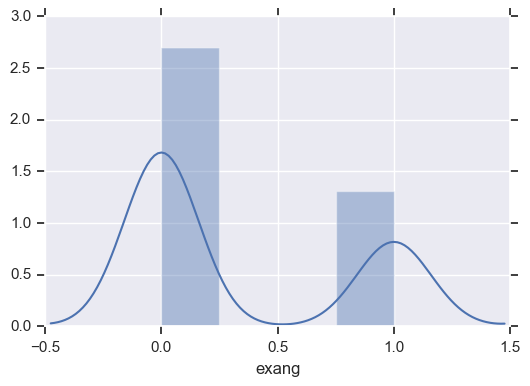

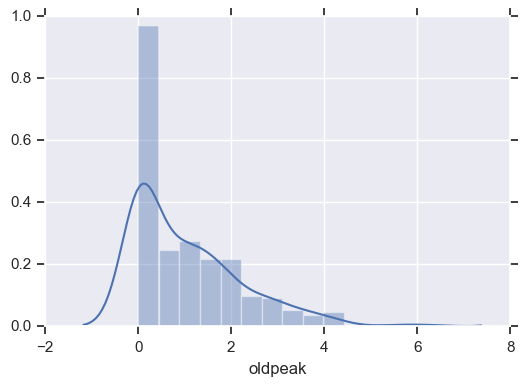

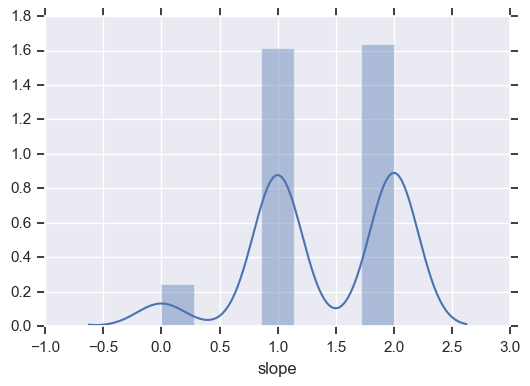

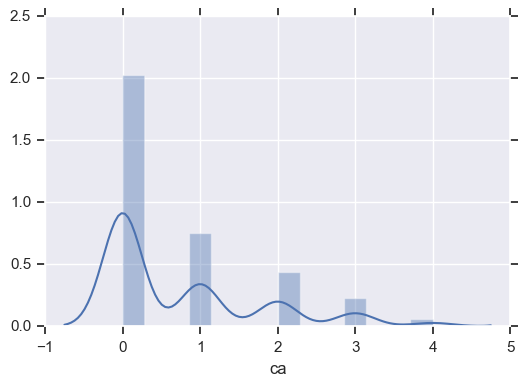

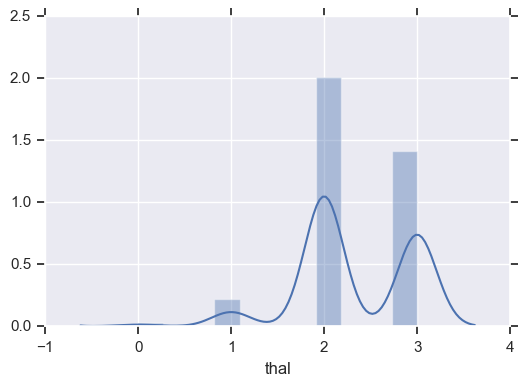

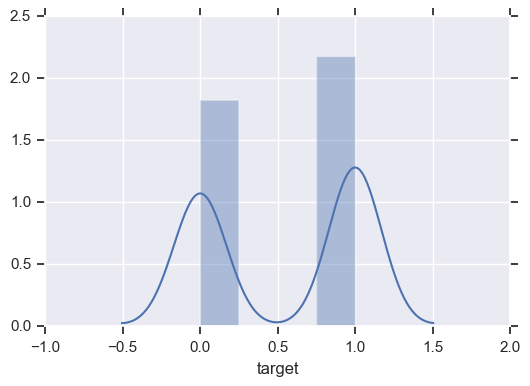

In [7]:
pd.set_option('display.max_rows', 50)
for column in hd.columns:
    sns.distplot(hd[column])
    plt.show()
    
# notice the imbalance in observations by sex

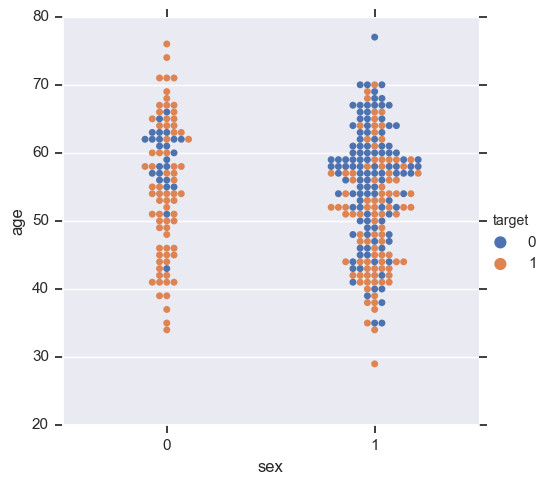

In [8]:
# explore demographic distribution
sns.catplot(x="sex", y="age", hue="target",
            kind="swarm", data=hd);
plt.show()

# women in the study appear to have a higher percentage of observations positive for heart disease
# both men and women in the study appaer to have a higher probability of heart disease at a younger age

In [9]:
#dig further into the relationship between sex and heart disease
pd.crosstab(hd.sex, hd.target).apply(lambda r: r/r.sum(), axis=1)

# 75% of women in our dataset have heart disease
# only 45% of men have heart disease

target,0,1
sex,,
0,0.250000,0.750000
1,0.550725,0.449275


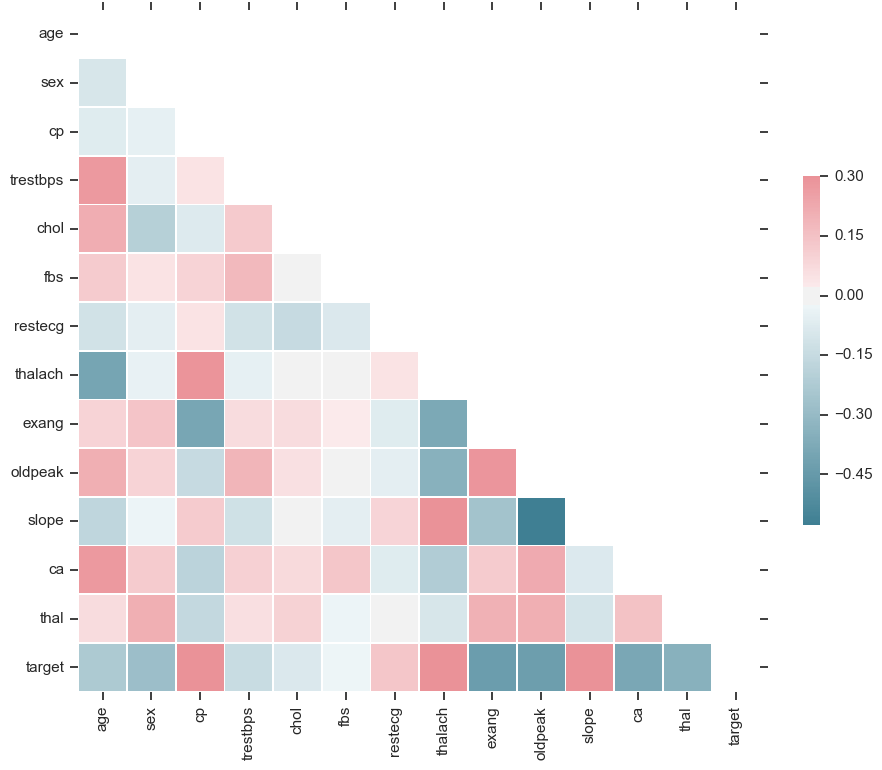

In [10]:
sns.set(style="white")

# Compute the correlation matrix
corr = hd.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# some moderate correlation present between:
# slope and oldpeak
# thalach and age
# exang and cp
# trestbps and age
# thalach and age
# oldpeak and exang
# slope and thalach

In [4]:
x = hd.drop('target',axis=1)
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [5]:
y = hd['target']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [5]:
# apply dimensionality reduction to reduce features to 2 dimensions for plotting

# linear
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)
x_pca.shape

NameError: name 'x' is not defined

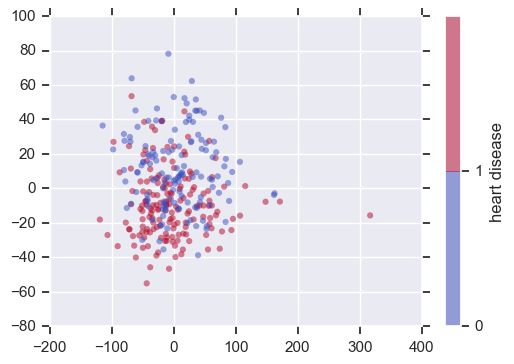

In [9]:
plt.scatter(x_pca[:,0], x_pca[:, 1], c=y, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('coolwarm',2))
plt.colorbar(label = 'heart disease',ticks=range(2))
plt.clim(0,2);
plt.show()

In [10]:
# nonlinear 
from sklearn.manifold import Isomap
iso=Isomap(n_components=2)
iso.fit(x)
data_projected = iso.transform(x)
data_projected.shape

(303, 2)

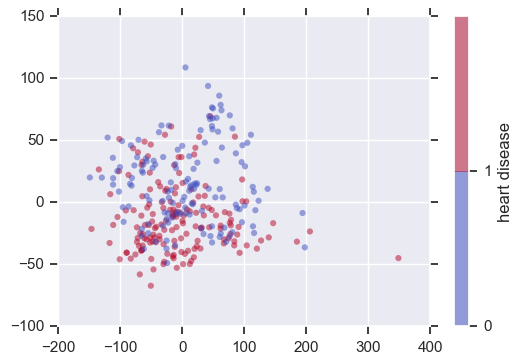

In [11]:
plt.scatter(data_projected[:,0], data_projected[:, 1], c=y, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('coolwarm',2))
plt.colorbar(label = 'heart disease',ticks=range(2))
plt.clim(0,2);
plt.show()

# Overall, the groups have some separation on the edges, but are not well separated in the center. 
# This will be a fun and challenging classification exercise

In [6]:
from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(xtrain.shape[0], n_iter=10, test_size=0.2, random_state=0)

C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
# start with Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(xtrain, ytrain)
y_model = model.predict(xtest)

print(accuracy_score(ytest, y_model))

# even with this extremely simple model, we obtain accuracy of 83%

0.8524590163934426


In [10]:
#54% of observations in dataset are positive for heart disease. Our models should perform significantly above 54% to be useful.
hd.target.sum() / hd.target.count()

0.5445544554455446

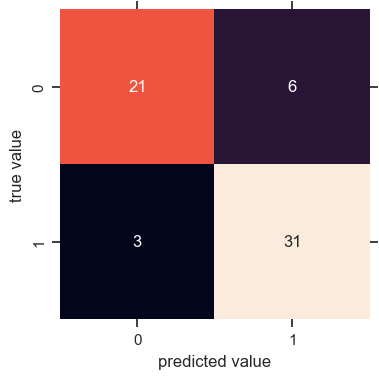

In [11]:
# examine errors with confusion matrix

mat = confusion_matrix(ytest, y_model)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

In [ ]:
# further tuning of naive bayes to improve performance

In [63]:
# try logistic regression

from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(random_state=0, multi_class='ovr', solver='liblinear', penalty='l1')
parameters = {
        'C': (0.01,0.1,0.5,0.9,0.99),
#        'multiclass': ('ovr','multinomial')
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

C 0.9
             precision    recall  f1-score   support

          0       0.85      0.81      0.83        27
          1       0.86      0.88      0.87        34

avg / total       0.85      0.85      0.85        61



In [74]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(random_state=0, penalty='l2')
parameters = {
        'multi_class': ('ovr','multinomial'),
        'solver': ('newton-cg','lbfgs'),
        'C': (0.01,0.1,0.5,0.9,0.99),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

C 0.99
multi_class ovr
solver lbfgs
             precision    recall  f1-score   support

          0       0.85      0.81      0.83        27
          1       0.86      0.88      0.87        34

avg / total       0.85      0.85      0.85        61



In [ ]:
# further tuning of logistic to obtain better results 

In [ ]:
# support vector machines

#try scaling to speed up model
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(xtrain)
xscaletrain = scaling.transform(xtrain)
Xscaletest = scaling.transform(xtest) 

from sklearn.svm import SVC #support vector classifier
model = SVC(kernel='linear', C=1E10)
model.fit(xscaletrain,ytrain)
y_model = model.predict(xtraintest)
accuracy_score(ytest, y_model)

In [50]:
# further tuning of SVM to obtain better results 
estimator = RandomForestClassifier(random_state=0)
estimator.get_params().keys()

dict_keys(['warm_start', 'oob_score', 'verbose', 'min_samples_split', 'criterion', 'max_leaf_nodes', 'n_jobs', 'max_depth', 'min_impurity_split', 'class_weight', 'bootstrap', 'min_weight_fraction_leaf', 'random_state', 'n_estimators', 'max_features', 'min_samples_leaf'])

In [51]:
# random forest

from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=0)
parameters = {
        'n_estimators': (10,50,100),
        'max_depth': (2,4,6,10),
        'min_samples_leaf': (2,3,5),
        'min_samples_split': (2,6,10),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

##model = RandomForestClassifier(n_estimators=1000, random_state=0)
##model.fit(xtrain,ytrain)
#ypred = model.predict(xtest)
##from sklearn import metrics
##y_model = model.predict(xtest)
##print(accuracy_score(ytest, y_model))
##print(metrics.classification_report(classifier.predict, ytest))
#mat = confusion_matrix(ytest, ypred)
#sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
#plt.xlabel('predicted value')
#plt.ylabel('true value')
#plt.show()

max_depth 2
min_samples_leaf 3
min_samples_split 2
n_estimators 50
             precision    recall  f1-score   support

          0       0.88      0.81      0.85        27
          1       0.86      0.91      0.89        34

avg / total       0.87      0.87      0.87        61



In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
estimator = LinearDiscriminantAnalysis()
estimator.get_params().keys()

dict_keys(['shrinkage', 'solver', 'tol', 'priors', 'n_components', 'store_covariance'])

In [ ]:
# further tuning of RF to obtain better results 

In [80]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

estimator = LinearDiscriminantAnalysis()
parameters = {
           'store_covariance': (0,0.01,0.1,0.5,0.9,1),
           'tol': (0,0.01,0.1,0.5,0.9,1),
           'n_components': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\

n_components 1
store_covariance 0
tol 0.9
             precision    recall  f1-score   support

          0       0.78      0.67      0.72        27
          1       0.76      0.85      0.81        34

avg / total       0.77      0.77      0.77        61



In [45]:
#linear discriminant analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

estimator = LinearDiscriminantAnalysis()
parameters = {
           'solver': ('lsqr','eigen'),
           'shrinkage': (0,0.01,0.1,0.5,0.9,1),
           'n_components': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

#model = LinearDiscriminantAnalysis(n_components=1)
#model.fit(xtrain, ytrain)
#y_model = model.predict(xtest)
#accuracy_score(ytest, y_model)

n_components 1
shrinkage 0
solver eigen
             precision    recall  f1-score   support

          0       0.86      0.70      0.78        27
          1       0.79      0.91      0.85        34

avg / total       0.83      0.82      0.82        61



In [ ]:
#further tuning of LDA

In [49]:
#gradient boosted machine

from sklearn.ensemble import GradientBoostingClassifier
estimator = GradientBoostingClassifier(random_state=0)
parameters = {
           'n_estimators': (5,10,25,75,100),
           'learning_rate': (0.01,0.1,0.5,0.9,0.95),
           'max_features': (1,2,3,4,5),
           'max_depth': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

#learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
#scores = {}
#scores_list = []
#for l in learning_rates:
#    model = GradientBoostingClassifier(n_estimators=20, learning_rate = l, max_features=2, max_depth = 2, random_state = 0)
#    model.fit(xtrain, ytrain)
    ##print("Learning rate: ", learning_rate)
    ##print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    ##print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))
    ##print()
#    y_model = model.predict(xtest)
#    scores[l] = accuracy_score(ytest, y_model)
#    scores_list.append(accuracy_score(ytest, y_model))
#print(scores_list)

learning_rate 0.5
max_depth 1
max_features 4
n_estimators 10
             precision    recall  f1-score   support

          0       0.85      0.81      0.83        27
          1       0.86      0.88      0.87        34

avg / total       0.85      0.85      0.85        61



In [ ]:
#further tuning

In [81]:
#knn

from sklearn.neighbors import KNeighborsClassifier

#dict_keys(['p', 'metric_params', 'algorithm', 'n_neighbors', 'leaf_size', 'metric', 'weights', 'n_jobs'])
estimator = KNeighborsClassifier()
parameters = {
           'n_neighbors': (2,6,10,15,20,25),
           'leaf_size': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
classifier.fit(xtrain, ytrain)
classifier.best_score_

best_parameters = classifier.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

y_model = classifier.predict(xtest)
print(metrics.classification_report(ytest, y_model))

#k_range = range(1,26)
#scores = {}
#scores_list = []
#for k in k_range:
#    model = KNeighborsClassifier(n_neighbors=k)
#    model.fit(xtrain,ytrain)
#    y_model = model.predict(xtest)
#    scores[k] = accuracy_score(ytest, y_model)
#    scores_list.append(accuracy_score(ytest, y_model))
#print(scores_list)

leaf_size 1
n_neighbors 20
             precision    recall  f1-score   support

          0       0.62      0.78      0.69        27
          1       0.78      0.62      0.69        34

avg / total       0.71      0.69      0.69        61



In [16]:
estimator.get_params().keys()

dict_keys(['p', 'metric_params', 'algorithm', 'n_neighbors', 'leaf_size', 'metric', 'weights', 'n_jobs'])

In [ ]:
#Stochastic gradient descent
sklearn.linear_model.SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False, n_iter=None)[source]

In [ ]:
#other notes
#check for leakage
#are there models where the vars should be scaled?
#how should we scale weights for each class
